In [46]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import json

from dataclasses import dataclass
from typing import List, Optional

# Load the dataset
data = pd.read_csv('Data4Good_Arolsen_Archives_50k.csv')

data.dropna(subset=["Geo Location"], inplace=True)

# Drop unnecessary column
data.drop('Unnamed: 0', axis=1, inplace=True)

# Ensure all values are strings and replace double double-quotes
data["Geo Location"] = data["Geo Location"].astype(str).apply(lambda x: x.replace('""', '"'))
# Ensure values are strings and remove surrounding quotes
data["Geo Location"] = data["Geo Location"].astype(str).apply(lambda x: x.strip('"'))
# Ensure values are strings and remove surrounding single and double quotes
data["Geo Location"] = data["Geo Location"].astype(str).apply(lambda x: x.strip("'").strip('"'))


# Define the structure of Paths
@dataclass
class Path:
    fromLabel: str
    toLabel: str
    index: int
    type: str

# Define the structure of Location inside Markers
@dataclass
class Location:
    lon: float
    lat: float

# Define the structure of Markers (location is now optional)
@dataclass
class Marker:
    location: Optional[Location]  # Can be None if missing
    label: str
    type: str

# Define the GeoLocation object that contains Paths and Markers
@dataclass
class GeoLocation:
    id: int  # Unique identifier for each GeoLocation object
    paths: List[Path]
    markers: List[Marker]

# Function to deserialize JSON into GeoLocation object
def deserialize_geo_location(json_text: str, geo_id: int) -> Optional[GeoLocation]:
    """Convert JSON text from the 'Geo Location' column into a GeoLocation object."""
    if not json_text or json_text in ["nan", "None"]:  # Handle missing or NaN values
        return None
    
    try:
        data = json.loads(json_text)

        # Deserialize Paths
        paths = [Path(**p) for p in data.get("paths", [])]  # Handle missing "paths" key safely

        # Deserialize Markers, handling missing 'location'
        markers = []
        for m in data.get("markers", []):  # Handle missing "markers" key safely
            location = Location(**m["location"]) if "location" in m else None  # Handle missing location
            markers.append(Marker(location=location, label=m["label"], type=m["type"]))

        return GeoLocation(id=geo_id, paths=paths, markers=markers)

    except json.JSONDecodeError:
        print(f"Error decoding JSON at ID {geo_id}: {json_text}")
        return None  # Return None if JSON is invalid

# Create a list to store all GeoLocation objects
geo_location_objects = []

# Loop through all rows in "Geo Location" column
for idx, geo_text in enumerate(data["Geo Location"]):
    geo_obj = deserialize_geo_location(geo_text, idx)  # Deserialize JSON into an object with an ID
    
    if geo_obj:  # Ensure it's valid before adding
        geo_location_objects.append(geo_obj)

# Print total valid GeoLocation objects
print(f"Total GeoLocation Objects Created: {len(geo_location_objects)}")


# Function to get a GeoLocation object by ID
def get_geo_location_by_id(geo_id: int) -> Optional[GeoLocation]:
    """Retrieve a GeoLocation object by its ID."""
    if 0 <= geo_id < len(geo_location_objects):
        return geo_location_objects[geo_id]
    else:
        print(f"Invalid ID {geo_id}: Not found.")
        return None

# Example: Get a specific GeoLocation object by ID
geo_id = 10  # Example: Access the 10th GeoLocation object
selected_geo = get_geo_location_by_id(geo_id)

if selected_geo:
    print(f"\nGeoLocation ID {geo_id}:")
    print(selected_geo)

    # Print its paths and markers
    print("\nPaths:")
    for path in selected_geo.paths:
        print(path)

    print("\nMarkers:")
    for marker in selected_geo.markers:
        print(marker)
else:
    print("Invalid or empty Geo Location data.")

selected_geo.markers.pop()
selected_geo.paths.pop()

geo_location_objects[geo_id] = selected_geo

def serialize_geo_location(geo_location: GeoLocation) -> str:
    """Convert a GeoLocation object back to a JSON string."""
    if geo_location is None:
        return "None"
    
    # Convert Paths back to dictionary format
    paths = [{"fromLabel": p.fromLabel, "toLabel": p.toLabel, "index": p.index, "type": p.type} for p in geo_location.paths]
    
    # Convert Markers back to dictionary format, handling missing locations
    markers = []
    for m in geo_location.markers:
        marker_dict = {"label": m.label, "type": m.type}
        if m.location:
            marker_dict["location"] = {"lon": m.location.lon, "lat": m.location.lat}  # Include location only if it exists
        markers.append(marker_dict)

    # Create the final dictionary structure
    geo_dict = {"paths": paths, "markers": markers}

    # Convert dictionary to JSON string
    return json.dumps(geo_dict, ensure_ascii=False)

# Apply serialization function to all GeoLocation objects
data["Geo Location"] = [serialize_geo_location(obj) for obj in geo_location_objects]

print("Serialization completed successfully! Data saved.")

print(data["Geo Location"][geo_id])

Total GeoLocation Objects Created: 49466

GeoLocation ID 10:
GeoLocation(id=10, paths=[Path(fromLabel='Lodz Pol', toLabel='Lodz', index=0, type=''), Path(fromLabel='Lodz', toLabel='Auschwitz', index=1, type=''), Path(fromLabel='Auschwitz', toLabel='Bergen - Belsen', index=2, type=''), Path(fromLabel='Bergen - Belsen', toLabel='Salzwedel', index=3, type=''), Path(fromLabel='Salzwedel', toLabel='Leipheim', index=4, type=''), Path(fromLabel='Leipheim', toLabel='Felda', index=5, type=''), Path(fromLabel='Felda', toLabel='Salzwedel', index=6, type=''), Path(fromLabel='Salzwedel', toLabel='Canada', index=7, type='')], markers=[Marker(location=Location(lon=19.4559833, lat=51.7592485), label='Lodz Pol', type='Birth Place'), Marker(location=Location(lon=19.4559833, lat=51.7592485), label='Lodz', type='Location'), Marker(location=Location(lon=19.2097782, lat=50.0343982), label='Auschwitz', type='Location'), Marker(location=None, label='Bergen - Belsen', type='Location'), Marker(location=Location

In [48]:
# Define the Journey object structure
@dataclass
class Journey:
    id: int  # Unique identifier for each journey (person)
    from_to: List[dict]  # List of "from-to" pairs as dictionaries

# Create a list of Journey objects
journey_objects = []

# Loop through each GeoLocation object to create Journey objects
for geo in geo_location_objects:
    # Extract "from-to" pairs for the current person
    from_to_pairs = [{"from": path.fromLabel, "to": path.toLabel} for path in geo.paths]
    
    # Create a Journey object for the person
    journey = Journey(id=geo.id, from_to=from_to_pairs)
    journey_objects.append(journey)

# Example: Access Journey for the 10th person
person_index = 12265
if 0 <= person_index < len(journey_objects):
    selected_journey = journey_objects[person_index]
    print(f"Journey ID {selected_journey.id}:")
    print(selected_journey.from_to)
else:
    print(f"Person with index {person_index} does not exist.")


Journey ID 12265:
[{'from': 'Merklingen', 'to': 'Mosbach / Baden'}, {'from': 'Mosbach / Baden', 'to': 'Südfrankr'}]


In [49]:
geo_trimmed = geo_location_objects[:1000]  # Use first 100 entries

from_to_matrix = []
for geo in geo_trimmed:
    for path in geo.paths:
        # Normalize 'from' states by grouping them into general locations
        from_location = path.fromLabel.split(",")[0].strip()  # Keep only city name
        to_location = path.toLabel.split(",")[0].strip()
        from_to_matrix.append([from_location, to_location])

from_to_df = pd.DataFrame(from_to_matrix, columns=["from", "to"])

print(from_to_df)

                    from            to
0                Wiekowo         Weser
1                  Weser        Berlin
2                 Berlin        Berlin
3                 Berlin       Gniezno
4         Laszczow Polen      Laszczow
..                   ...           ...
358             Warschau      Warschau
359             Warschau     Feldafing
360  Neckar Bischofsheim  Niedermendig
361         Niedermendig         Mayen
362                Mayen         Polen

[363 rows x 2 columns]


In [50]:
from scipy.sparse import dok_matrix, csr_matrix
import numpy as np
import pandas as pd

geo_trimmed = geo_location_objects[:1000]  # Use first 100 entries

# Step 1: Extract all 'from-to' pairs into a DataFrame
from_to_matrix = []
for geo in geo_trimmed:
    for path in geo.paths:
        # Normalize 'from' states by grouping them into general locations
        from_location = path.fromLabel.split(",")[0].strip()  # Keep only city name
        to_location = path.toLabel.split(",")[0].strip()
        from_to_matrix.append([from_location, to_location])

from_to_df = pd.DataFrame(from_to_matrix, columns=["from", "to"])

# Step 2: Count occurrences of each 'from-to' pair globally
transition_counts = from_to_df.value_counts().reset_index(name="count")

# Step 3: Assign unique integer indices to each aggregated state
unique_states = sorted(set(from_to_df["from"]).union(set(from_to_df["to"])))
state_to_idx = {state: idx for idx, state in enumerate(unique_states)}

# Debug: Ensure correct indexing
print(f"Total unique aggregated states: {len(unique_states)}")
print("Sample state mapping:", list(state_to_idx.items())[:10])

# Step 4: Create a sparse transition matrix with the CORRECT size
n_states = len(unique_states)
transition_matrix = dok_matrix((n_states, n_states), dtype=np.float64)

# Step 5: Populate the sparse matrix safely
for _, row in transition_counts.iterrows():
    from_state, to_state = row["from"], row["to"]

    # Ensure states exist before mapping
    if from_state in state_to_idx and to_state in state_to_idx:
        from_idx = state_to_idx[from_state]
        to_idx = state_to_idx[to_state]
        
        # Debug: Ensure indices are within valid range
        if from_idx >= n_states or to_idx >= n_states:
            print(f"⚠️ Error: Index out of range! {from_state} → {to_state} (Indexes: {from_idx}, {to_idx})")
            continue
        
        transition_matrix[from_idx, to_idx] = row["count"]
    else:
        print(f"⚠️ Skipping invalid transition: {from_state} → {to_state}")

# Debug: Check if matrix contains non-zero values
print(f"✅ Transition matrix (non-zero elements): {transition_matrix.nnz}")

# Step 6: Normalize using total departures from each state
row_sums = np.array(transition_matrix.sum(axis=1)).flatten()  # Get total departures from each 'from' state

for i in range(n_states):
    if row_sums[i] > 0:  # Avoid division by zero
        transition_matrix[i, :] /= row_sums[i]  # Normalize row-wise

# Convert sparse matrix to compressed format for efficiency
transition_matrix = transition_matrix.tocsr()

# Debug: Print some non-zero transitions to check probabilities
non_zero_indices = transition_matrix.nonzero()
for idx in range(min(10, len(non_zero_indices[0]))):  # Print first 10 non-zero values
    row, col = non_zero_indices[0][idx], non_zero_indices[1][idx]
    print(f"Transition from {unique_states[row]} → {unique_states[col]}: {transition_matrix[row, col]}")

print("\n✅ Transition Matrix successfully created and normalized.")

print(transition_matrix)

Total unique aggregated states: 2581
Sample state mapping: [('(  Krefelt', 0), ('( Gefängn', 1), ('( Lesnow', 2), ('-', 3), ('- Auszug', 4), ('- Belsen', 5), ('- Belsens', 6), ('- Kaserne', 7), ('- Pocking', 8), ('- mzdorf', 9)]
✅ Transition matrix (non-zero elements): 3141
Transition from (  Krefelt → Kernerlesch: 1.0
Transition from ( Gefängn → Normades: 1.0
Transition from - → Belsen: 0.5
Transition from - → Schöneberg: 0.5
Transition from - Belsen → Bad Salzschlirf: 0.2
Transition from - Belsen → Bergen - Belsen: 0.2
Transition from - Belsen → Hahn: 0.2
Transition from - Belsen → Salzwedel: 0.2
Transition from - Belsen → Theresienstadt: 0.2
Transition from -Bels → Israel: 1.0

✅ Transition Matrix successfully created and normalized.
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3141 stored elements and shape (2581, 2581)>
  Coords	Values
  (0, 1024)	1.0
  (1, 1532)	1.0
  (3, 163)	0.5
  (3, 1949)	0.5
  (5, 121)	0.2
  (5, 198)	0.2
  (5, 811)	0.2
  (5, 1879)	0.2
  (5, 

In [18]:
# Check if state indexing is correct
print(f"Total unique states: {len(states)}")
print("Sample state mapping:", list(state_to_idx.items())[:10])

# Ensure transition_counts only contains valid states
print("\nChecking if all 'from' and 'to' are mapped correctly:")
invalid_from = transition_counts[~transition_counts["from"].isin(states)]
invalid_to = transition_counts[~transition_counts["to"].isin(states)]
print(f"Invalid 'from' states:\n{invalid_from}")
print(f"Invalid 'to' states:\n{invalid_to}")


Total unique states: 350
Sample state mapping: [('Worochta', 0), ('Lo dz', 1), ('Radwan Polen', 2), ('Kassa Ung', 3), ('Rudau Krs Ortels burg', 4), ('Langbilau , Hundsfeld', 5), ('Vernazza', 6), ('Wala i.Drenkfurt', 7), ('Eschwege', 8), ('Pinsk', 9)]

Checking if all 'from' and 'to' are mapped correctly:
Invalid 'from' states:
Empty DataFrame
Columns: [from, to, count]
Index: []
Invalid 'to' states:
Empty DataFrame
Columns: [from, to, count]
Index: []


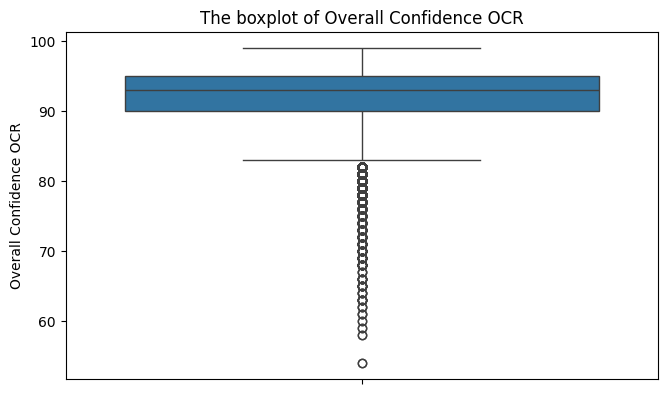

The number of outliers in the dataset: 1628


In [131]:
numeric_cols = data.select_dtypes(include = ['float64']).columns

plt.figure(figsize=(25, 15))  

for column in range(len(numeric_cols)):
    plt.subplot(4, 4, column + 1)
    sns.boxplot(y = data[numeric_cols[column]])  
    plt.title(f'The boxplot of {numeric_cols[column]}')  
    
plt.tight_layout()
plt.show()

def count_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))].shape[0]

print('The number of outliers in the dataset:', count_outliers(data, 'Overall Confidence OCR'))

In [132]:
leng = data.__len__()

data_train_set = data.iloc[: np.ceil(leng * 0.65).astype(int)].copy()
data_val_set = data.iloc[np.ceil(leng * 0.65).astype(int) : np.ceil(leng * 0.8).astype(int)].copy()
data_test_set = data.iloc[np.ceil(leng * 0.8).astype(int) :].copy()

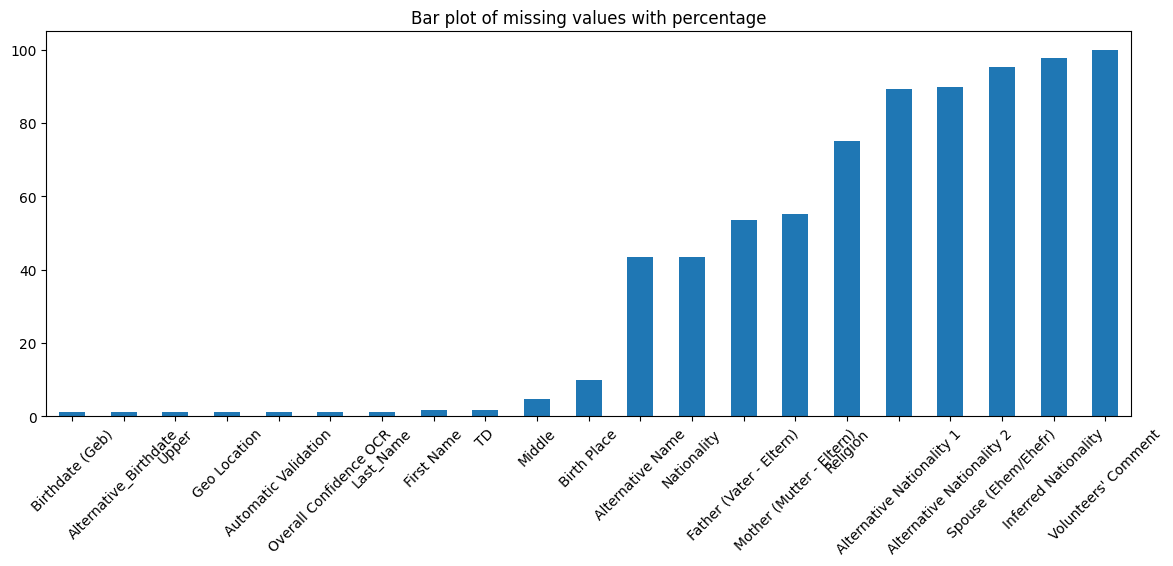

In [133]:
plt.figure(figsize=(14,5))
missing = data_train_set.isnull().sum() / data_train_set.shape[0] *100
missing = missing.sort_values().plot.bar()

plt.xticks(rotation = 45)
plt.title('Bar plot of missing values with percentage')
plt.show()

In [134]:
data["Nationality"] = data["Nationality"].str.replace(r"(?i)\bFormerly\b", "", regex=True).str.strip()

data["Nationality"] = data["Nationality"].str.lower().replace(r"stateless", np.nan, regex=True)

Using FuzzyWuzzy to have consistency in nationatilies

In [136]:
from fuzzywuzzy import process
import pandas as pd

# Convert valid nationalities list to lowercase
valid_nationalities = [
    # Common nationalities (ISO 3166)
    "afghan", "albanian", "algerian", "american", "andorran", "angolan", "argentine", "armenian", "australian", "austrian",
    "azerbaijani", "bahamian", "bahraini", "bangladeshi", "barbadian", "belarusian", "belgian", "belizean", "beninese", "bhutanese",
    "bolivian", "bosnian", "botswanan", "brazilian", "british", "bruneian", "bulgarian", "burkinabé", "burmese", "burundian",
    "cambodian", "cameroonian", "canadian", "cape verdean", "central african", "chadian", "chilean", "chinese", "colombian",
    "comoran", "congolese", "costa rican", "croatian", "cuban", "cypriot", "czech", "danish", "djiboutian", "dominican",
    "dutch", "east timorese", "ecuadorean", "egyptian", "emirati", "equatorial guinean", "eritrean", "estonian", "eswatini",
    "ethiopian", "fijian", "finnish", "french", "gabonese", "gambian", "georgian", "german", "ghanaian", "greek",
    "grenadian", "guatemalan", "guinean", "guyanese", "haitian", "honduran", "hungarian", "icelandic", "indian", "indonesian",
    "iranian", "iraqi", "irish", "israeli", "italian", "ivorian", "jamaican", "japanese", "jordanian", "kazakh",
    "kenyan", "kiribati", "kuwaiti", "kyrgyz", "lao", "latvian", "lebanese", "lesotho", "liberian", "libyan",
    "liechtensteiner", "lithuanian", "luxembourgish", "macedonian", "malagasy", "malawian", "malaysian", "maldivian",
    "malian", "maltese", "marshallese", "mauritanian", "mauritian", "mexican", "micronesian", "moldovan", "monacan",
    "mongolian", "montenegrin", "moroccan", "mozambican", "myanmar", "namibian", "nauruan", "nepalese", "new zealander",
    "nicaraguan", "nigerian", "north korean", "norwegian", "omani", "pakistani", "palauan", "palestinian", "panamanian",
    "papua new guinean", "paraguayan", "peruvian", "philippine", "polish", "portuguese", "qatari", "romanian", "russian",
    "rwandan", "saint lucian", "salvadoran", "samoan", "saudi", "scottish", "senegalese", "serbian", "seychellois",
    "sierra leonean", "singaporean", "slovak", "slovenian", "solomon islander", "somali", "south african", "south korean",
    "south sudanese", "spanish", "sri lankan", "sudanese", "surinamese", "swedish", "swiss", "syrian", "taiwanese",
    "tajik", "tanzanian", "thai", "togolese", "tongan", "trinidadian", "tunisian", "turkish", "turkmen", "tuvaluan",
    "ugandan", "ukrainian", "uruguayan", "uzbek", "venezuelan", "vietnamese", "welsh", "yemeni", "zambian", "zimbabwean",

    # Historical nationalities
    "austro-hungarian", "prussian", "bohemian", "ottoman", "soviet", "yugoslav", "czechoslovak", "west german", "east german",
    "rhodesian", "serbo-croatian", "mandarin", "manchu", "ming", "byzantine",

    # Stateless or refugee identities
    "stateless", "refugee", "displaced", "unknown",

    # Manually added for necessity
    "yugoslavian", "ussr"
]

# Manual correction mapping for specific cases
manual_corrections = {
    "argentinian": "argentine",
    "luxembourger": "luxembourgish",
    "germna": "german",  # Common OCR mistake
    "polan": "polish"  # Common OCR mistake
}

# Convert all nationalities in data to lowercase and strip spaces
data["Nationality"] = data["Nationality"].str.lower().str.strip()

# Apply manual corrections first
data["Nationality_Corrected"] = data["Nationality"].replace(manual_corrections)

# Fuzzy matching function for remaining uncorrected values
def fuzzy_correct(nationality):
    if pd.isna(nationality):  # Skip NaN values
        return None
    match, score = process.extractOne(nationality, valid_nationalities)
    return match if score > 85 else nationality  # Keep original if match is weak

# Apply fuzzy matching for remaining uncorrected values
data["Nationality_Corrected"] = data["Nationality_Corrected"].apply(fuzzy_correct)

# Identify cases where fuzzy matching changed the nationality
data_fuzzy_changed = data[data["Nationality"] != data["Nationality_Corrected"]]

# Print fuzzy-matched values
print("Fuzzy-matched corrections:")
print(data_fuzzy_changed[["Nationality", "Nationality_Corrected"]])

# Identify remaining unrecognized nationalities
unrecognized = data[~data["Nationality_Corrected"].isin(valid_nationalities)]
print("\nRemaining Unrecognized Nationalities:")
print(unrecognized["Nationality_Corrected"].unique())

Fuzzy-matched corrections:
      Nationality Nationality_Corrected
1             NaN                  None
3             NaN                  None
7             NaN                  None
9             NaN                  None
10            NaN                  None
...           ...                   ...
49990         NaN                  None
49991         NaN                  None
49995         NaN                  None
49996         NaN                  None
49997         NaN                  None

[26115 rows x 2 columns]

Remaining Unrecognized Nationalities:
[None 'naesterreichisch' '11t' 'nital' 'utach' 'bilg' 'jugalv' 'etlo'
 'najugool' 'riechisch' '1ex' 'behandelt' 'maret' 'litener' 'pranzo'
 'extl' 'amstellaan' 'rusg' 'disa' 'rheinmetall' 'russld' 'pinneberg'
 'atestenlos' 'ydi' 'staatlos' 'fresr' 'gem' 'nierdl' 'img' 'tpoln'
 'citizenshi' 'canho' 'usacsr' 'gator' 'chit' 'rapoln' 'tzia' 'ungarisc'
 'tentsch' '1a' 'loot' 'rumaenisch' 'ular' 'franzoes' 'parter' 'osechs'
 'naro

In [ ]:
print(data_fuzzy_changed['Nationality_Corrected'].value_counts())

TypeError: the JSON object must be str, bytes or bytearray, not float

In [141]:
# Find nationalities not in the valid list
valid_nationalities.append(None)
data_unrecognized = data[~data["Nationality_Corrected"].isin(valid_nationalities)]
# Show the indexes and the unrecognized nationalities
data_nationality_cleaned = data[~data["Nationality_Corrected"].isin(data_unrecognized['Nationality_Corrected'])].reset_index(drop=True)

# Print the cleaned data
print("Cleaned Data without Unrecognized Nationalities:")
print(data_nationality_cleaned)

Cleaned Data without Unrecognized Nationalities:
         Last_Name            First Name       Alternative Name  \
0      KIERZKOWSKA  Mieczyslawa Marianna       verh. KUROSZCZYK   
1            GRUER            Pesia Pese       verh. PINCZANSKI   
2          SPRITZR                 Moses                    NaN   
3        ROSENBERG                Mosche                    NaN   
4      HOERNITZVON       LANKISCH Arthur                    NaN   
...            ...                   ...                    ...   
49423    HACHNOCHI                 Lissy          verh.BERNHEIM   
49424       REDZEL             Ernestina  HETZEL, geb. ROSENTAL   
49425        BOLLE                Jansje         verh.HAMBURGER   
49426        WOLFE          Sarah Szeren            geb. BERGER   
49427       WEGNER         Anton Anthony                    NaN   

      Father (Vater - Eltern) Mother (Mutter - Eltern) Spouse (Ehem/Ehefr)  \
0                   Wladyslaw          Pelagie Wozniak              

In [139]:
%pip install python-Levenshtein

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [149]:
#data_nationality_cleaned.drop('Inferred Nationality', inplace=True, axis=1)
print(data_nationality_cleaned[data_nationality_cleaned['Birth Place'].isin(data_nationality_cleaned['Birth Place'].value_counts()[lambda x: x > 3].index)][['Birth Place']])


      Birth Place
3        Warschau
7       Pabianice
9        Lodz Pol
10          unbek
13        Zalesie
...           ...
49408  Ostrolenka
49414      Padova
49420   Sosnowicz
49423       Lomza
49425   Amsterdam

[15772 rows x 1 columns]


In [ ]:
def determine_objective(feature):
    if feature.dtype.kind == 'f':
        return 'regression'
    elif len(feature.value_counts()) == 2:
        return 'binary'
    else:
        return 'multiclass'

inputation_models = {}

categorical_features =  data_train_set.select_dtypes(include = ['object']).columns.tolist()

def Training_Inputation_Models(dataset):
    columns = dataset.columns.tolist()
    columns.remove('RainTomorrow')

    for target in columns:
        
        indices = dataset.index[dataset[target].isna()]

        if indices.empty:
            continue

        """
        Dropping columns which target contains NaN values and saving corresponding features in X_target.
        It will be used for predicting dropped NaN values.
        """
        if not indices.empty:
            X_target = dataset.loc[indices].drop(target, axis = 1)

        dropped_data = dataset.dropna(subset = target)

        X_train, Y_train = dropped_data.drop(target, axis = 1), dropped_data[target]

        """
        Parameters of LightGBM model
        """
        objective = determine_objective(dataset[target])

        params = {
            'objective': objective,                  # using regression, binary or multiclass model
            'boosting': 'gbdt',                      # model uses Gradient Boosting which aimed to minimize loss (error)
            'learning_rate': 0.1,                    # the step which model makes in each iteration for minimizing loss
            'num_leaves': 100,                       # number of leaves for tree model
            'verbose': -1,                           # force model not to show additional text information
            'device_type': 'gpu'                     # it says to algorithm to use gpu
        }

        if objective == 'multiclass':
            params['num_class'] = len(dataset[target].unique())

        """
        As there is no test case, we train our model with full dataset (after dropping NaN target values).
        """
        train_set = lgb.Dataset(X_train, label = Y_train)

        model = lgb.train(params, train_set, num_boost_round = 100)
        if not indices.empty:
            Y_target = model.predict(X_target, num_iteration = model.best_iteration)
            
            """
            Writing predicted targets back to the data which also helps to have richer dataset in each iteration.
            """
            dataset.loc[indices, target] = Y_target
        
        inputation_models[target] = model

def Inputation_Of_Missing_Values(dataset):

    nan_contained_cols = dataset.columns[dataset.isna().any()].tolist()

    for target in nan_contained_cols:
        indices = dataset.index[dataset[target].isna()]

        X_target = dataset.loc[indices].drop(target, axis = 1)
        Y_target = inputation_models[target].predict(X_target)

        dataset.loc[indices, target] = Y_target


Training_Inputation_Models(data_train_set)
Inputation_Of_Missing_Values(data_val_set)
Inputation_Of_Missing_Values(data_test_set)